Complete the exercises below For **Assignment #4**.

Use **Markdown** cells for the non-code answers.

In this assignment we will work with the data underlying the *FiveThirtyEight* article ["Higher Rates Of Hate Crimes Are Tied To Income Inequality"](https://fivethirtyeight.com/features/higher-rates-of-hate-crimes-are-tied-to-income-inequality/).

Load the `tidymodels`, `readr`, and `moderndive` packages in the cell below.

In [3]:
library('readr')
library('tidymodels')
library('tidyverse')
library('moderndive')

We can read the data from a **CSV file** at the following URL: [http://bit.ly/2ItxYg3](http://bit.ly/2ItxYg3).

Use the `read_csv` function to read the data into our R session. Call the new table `hate_crimes`.

In [4]:
hate_crimes <- read.csv("http://bit.ly/2ItxYg3") |>
    filter(urbanization %in% c('high', 'low')) |>
    select(income, hs, urbanization) |>
    mutate(urbanization = forcats::fct_drop(urbanization)) |>
    drop_na()

head(hate_crimes)

,income,hs,urbanization
,<int>,<int>,<fct>
1,46686,83,low
2,51710,90,low
3,54310,85,high
4,54916,86,high
5,57522,87,high
6,58633,85,high


Next, let’s add the high-school degree variable into the mix by creating a scatterplot showing:

- Income on the y-axis (this is the `income` variable)
- Percent of adults 25 or older with a high school degree on the x-axis (this is the `hs` variable)
- The points colored by level of urbanization in a region (this is the variable `urbanization`)


**In addition, add a line of best fit (regression line) for each level of the variable urbanization (one for “low”, one for “high”).**

*Add the regression lines to the plot using the `geom_parallel_slopes` function from the `moderndive` package. This function will draw the regression lines based on fitting a regression model with parallel slopes (i.e., with no interaction between `hs` and `urbanization`).*

Warning message:
“`geom_parallel_slopes()` doesn't need a `method` argument ("lm" is used).”


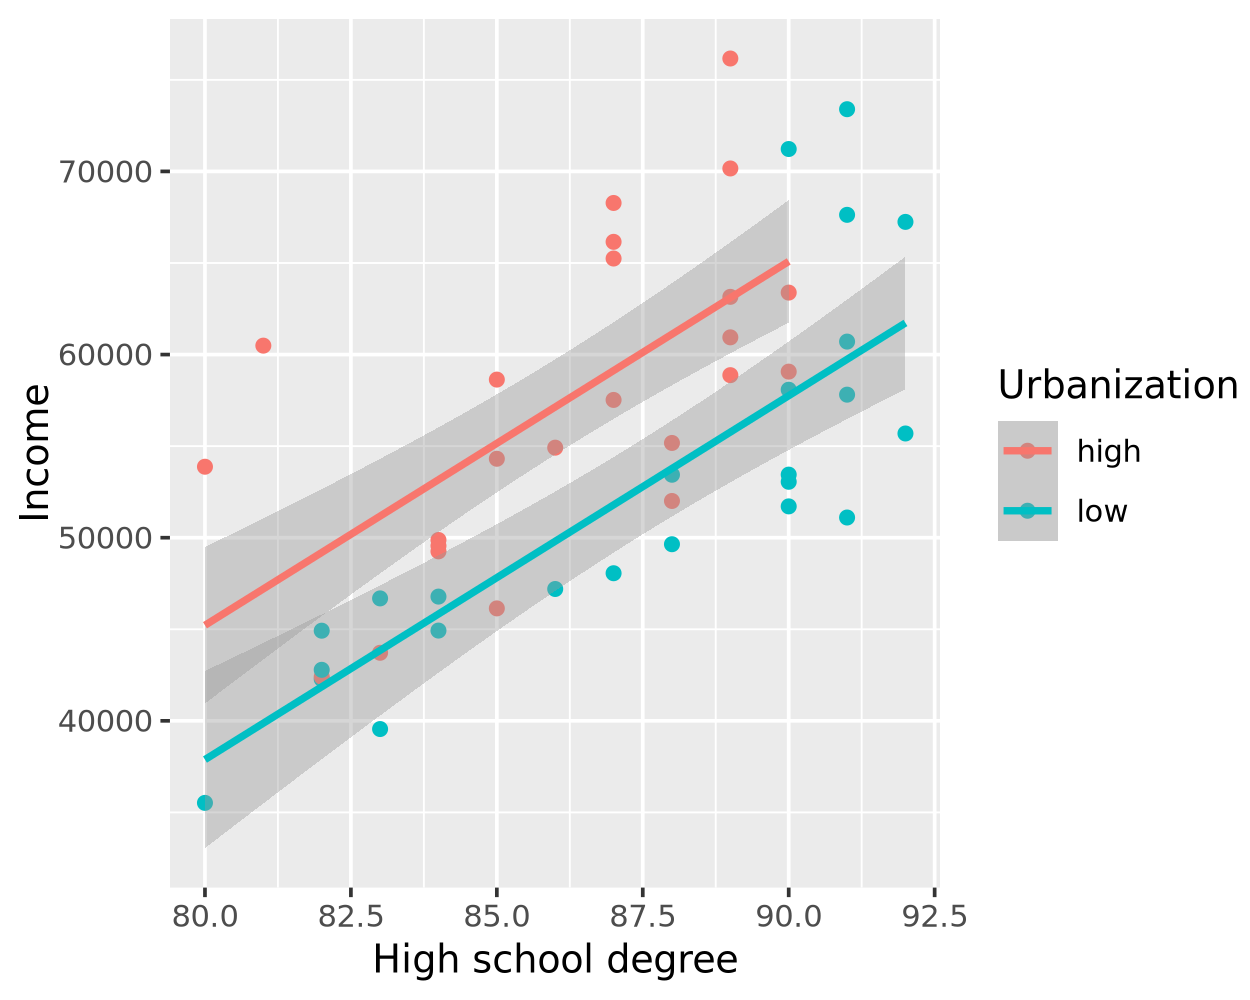

In [11]:
ggplot(hate_crimes, aes(y = income, x = hs, color = urbanization)) +
    geom_point() +
    geom_parallel_slopes(aes(group = urbanization), method = "lm") +
    labs(x = "High school degree", y = "Income", color = "Urbanization")




❓Which regression line (high urbanization or low urbanization) appears to have the larger intercept?

**Answer:**

High urbanization regression line appears to have the larger y-intercept.


Now let’s create a second scatterplot using the same variables, but this time draw the regression lines using `geom_smooth(method = "lm")`, which will allow for separate, non-parallel slopes for each urbanization group. 

**Code your scatter plot in the cell below.**

`geom_smooth()` using formula = 'y ~ x'


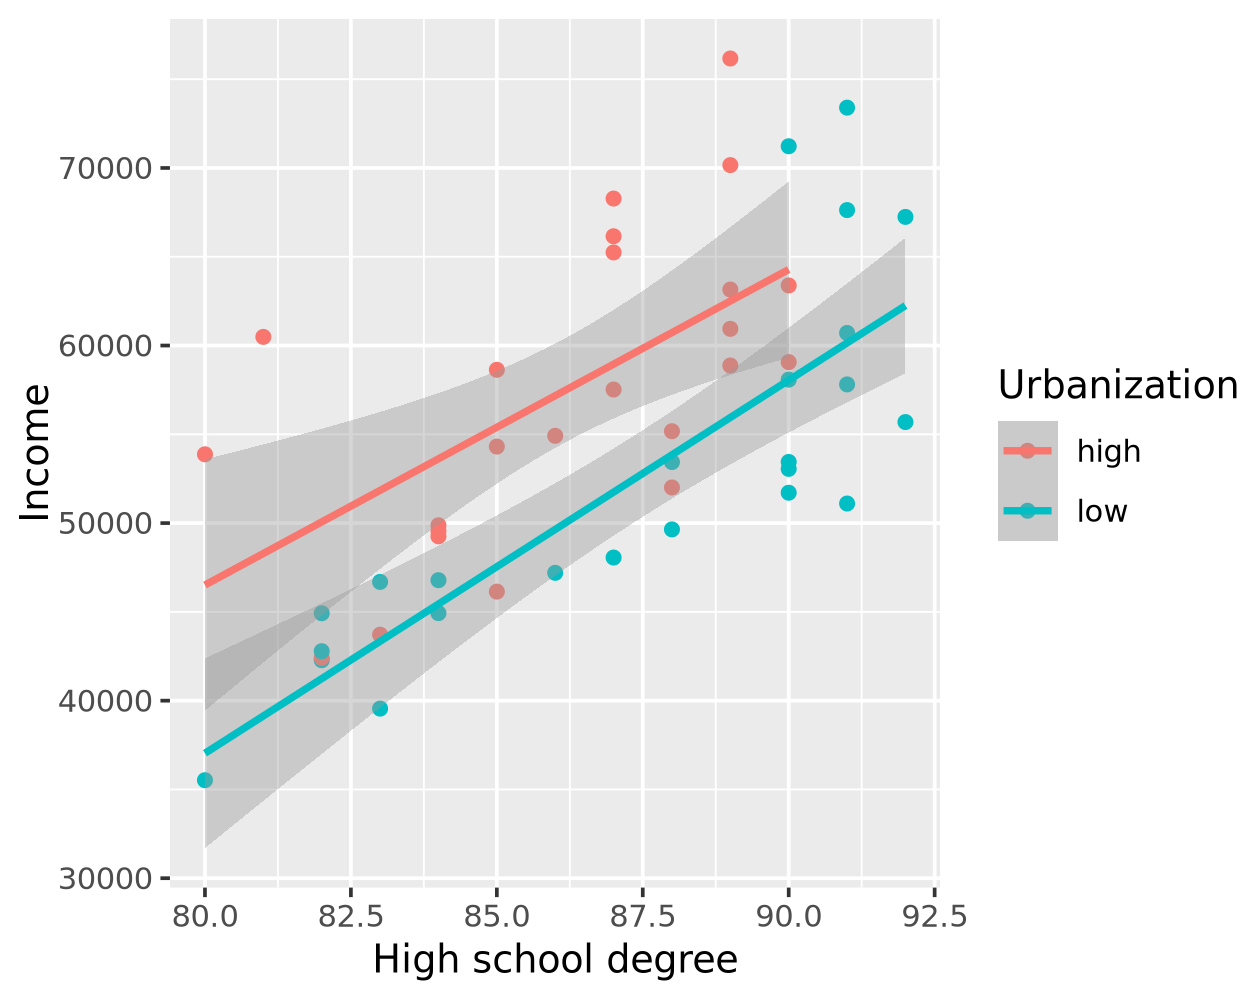

In [12]:
ggplot(hate_crimes, aes(y = income, x = hs, color = urbanization)) +
    geom_point() +
    geom_smooth(method = "lm") +
    labs(x = "High school degree", y = "Income", color = "Urbanization")



❓Based on visually comparing the two models shown above, do you think it would be best to run a “parallel slopes” model (i.e. a model that estimates one shared slope for the two levels of urbanization), or a more complex “interaction model” (i.e. a model that estimates a separate slope for the two levels of urbanization)?

**Answer:**

Based on the visuals alone, it looks like the parallel slopes model has smaller residuals than the interaction model indicating that the parallel slopes fit both levels' data better.



Fit the following two regression models that examine the relationship between household `income` (as response variable), and high-school education (`hs`) and `urbanization` as explanatory variables:

1. A parallel slopes model (i.e., no interaction between `hs` and `urbanization`). ❗️Save the data recipe and model under the variables `ps_rec` and `ps_mod`, respectively. 
1. A non-parallel slopes model (i.e., allow `hs` and `urbanization` to interact in your model). ❗️Save the data recipe and model under the variable: `nps_rec` and `nps_mod`, respectively.

**Code you your models in the cell below.**

In [13]:
# parallel slopes model

ps_rec = recipe(income ~ hs + urbanization, data = hate_crimes) |> 
    step_naomit(everything()) |>   # remove missing values
    step_dummy(urbanization) |>    # dummy encode the urbanization variable
    prep()                         # run the recipe on the training data provided

mod = linear_reg() |> set_engine('lm')

ps_mod = mod |> fit(income ~ ., juice(ps_rec))

ps_mod

parsnip model object


Call:
stats::lm(formula = income ~ ., data = data)

Coefficients:
     (Intercept)                hs  urbanization_low  
         -113725              1987             -7333  


In [7]:
# non-parallel slopes model

# ❗️ you can use most of the code above, just add step_interact(~ starts_with("urbanization"):hs) to the recipe and
#    switch the variable names...

nps_rec = recipe(income ~ hs + urbanization, data = hate_crimes) |> 
    step_interact(~ starts_with("urbanization"):hs) |>
    step_naomit(everything()) |>   # remove missing values
    step_dummy(urbanization) |>    # dummy encode the urbanization variable
    prep()                         # run the recipe on the training data provided

mod = linear_reg() |> set_engine('lm')

nps_mod = mod |> fit(income ~ ., juice(nps_rec))

nps_mod



parsnip model object


Call:
stats::lm(formula = income ~ ., data = data)

Coefficients:
         (Intercept)                    hs  urbanizationlow_x_hs  
              -95647                  1777                   324  
    urbanization_low  
              -35394  


The following code creates a table of your model predictions over the training data. Calculate the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) (R<sup>2</sup>) for each model:

```r
rbind(
    augment(ps_mod, juice(ps_rec)) |> select(income, .pred, .resid) |> mutate(model = "parallel_slopes"),
    augment(nps_mod, juice(nps_rec)) |> select(income, .pred, .resid) |> mutate(model = "interaction")
)
```

1. Group rows by the `model` variable (use the `group_by` function).
1. Calculate the variance of income over the variance of your predictions for each model using the "grouped" data from the step above (use `summarize(r_squared = var(.pred) / var(income))`).

In [8]:
train = rbind(
    augment(ps_mod, juice(ps_rec)) |> select(income, .pred, .resid) |> mutate(model = "parallel_slopes"),
    augment(nps_mod, juice(nps_rec)) |> select(income, .pred, .resid) |> mutate(model = "interaction")
) |>
    group_by(model) |>
    summarize(r_squared = var(.pred) / var(income))

train

model,r_squared
<chr>,<dbl>
interaction,0.5746731
parallel_slopes,0.5716112


🎶 Note: you can also use the `glance` function with a model as input to find the coefficient of determination.

In [9]:
glance(ps_mod)
glance(nps_mod)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.5716112,0.5525717,6325.667,30.02238,5.204241e-09,2,-486.6739,981.3479,988.8327,1800633086,45,48


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.5746731,0.5456735,6374.244,19.81661,2.814509e-08,3,-486.5018,983.0035,992.3595,1787763166,44,48


❓Compare the adjusted proportion of variance accounted for in each model. Based on this comparison, which model do you prefer? Why? 

**Answer:**

Going based off of the adjusted r-squared value for each model, I would prefer the parallel model becuase it has <i>slightly</i> better fit than the interation model.



❓Using your preferred model, based on your regression model parameters (and the data visualizations), is `income` greater in states that have lower or higher levels of `urbanization`? By how much?

**Hint:** use the `tidy` function with your model as input to access the parameters in a nice table.

**Answer:**

Income is greater in states that have higher levels of urbanization by 62,320.

In [14]:
# Find the intercept for income by urbanization
# Model for income by urbanization (no hs variable)
model <- lm(income ~ urbanization, data = hate_crimes)

# Show the model summary to get coefficients
summary(model)



Call:
lm(formula = income ~ urbanization, data = hate_crimes)

Residuals:
     Min       1Q   Median       3Q      Max 
-17099.4  -6349.6   -429.3   5514.9  20776.6 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)        57470       1885   30.50   <2e-16 ***
urbanizationlow    -4850       2665   -1.82   0.0753 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9233 on 46 degrees of freedom
Multiple R-squared:  0.06715,	Adjusted R-squared:  0.04687 
F-statistic: 3.311 on 1 and 46 DF,  p-value: 0.07532


❓For every one percentage point increase of high-school educated adults in a state (`hs` variable), what is the associated average increase in `income`?

**Answer:**

Going off of the parallel slope model, the average increase in income for every high-school educated adult is 1,987.

